# Tarea 0

### Configuración inicial

Primero, se debe crear un entorno virtual para evitar incompatibilidades con el resto del sistema. La celda de abajo se debe copiar y pegar en la terminal antes de correr el notebook.

In [1]:
%%sh
if [ ! -d ".venv" ]; then
    python3 -m venv .venv
    echo "Virtual environment created."
else
    echo "Virtual environment already exists."
fi

Virtual environment created.


Luego, se debe crear un entorno virtual e instalar las dependencias de Python necesarias.

In [2]:
import os
import platform

GREEN = '\033[92m'
BLUE = '\033[94m'
YELLOW = '\033[93m'
RED = '\033[91m'
RESET = '\033[0m'

system = platform.system().lower()

if system in ['linux', 'darwin']:  #*Linux or macOS
    activate_script = ".venv/bin/activate"
    print(f"To activate: {GREEN}source {activate_script}{RESET}")
elif system == 'windows':
    activate_script = ".venv\\Scripts\\activate.bat"
    print(f"To activate: {GREEN}{activate_script}{RESET}")
else:
    print(f"{RED}Unknown OS. Please activate manually.{RESET}")

if os.path.exists(".venv"):
    print(f"{BLUE}Virtual environment found.{RESET}")
else:
    print(f"{YELLOW}Virtual environment not found. Please create it first.{RESET}")

To activate: source .venv/bin/activate
Virtual environment found.


In [3]:
%%bash
# Reemplaza esta línea por el código en verde que te apareció en la salida de la celda inmediatamente anterior a esta

In [4]:
!pip install numpy networkx matplotlib scipy pandas ipywidgets

## Parámetros iniciales <a id="param"></a>

In [5]:
p_values: list[float] = [i/10 for i in range (1, 10)]
n_values: list[int] = [n for n in range (2, 10)]

## Funciones extra

Su objetivo es reutilizar código y abstraer diversos procesos para enfocarse en el análisis de complejidad de los dos algoritmos

In [6]:
import numpy as np

def build_p_matrices(chain: int = 1,
                     n_values: list[float] = [n for n in range(2, 5)],
                     p_values: list[float] = [n/10 for n in range (1, 10)],
                     e_values: list[float] = None) -> list[np.array]:
    """
    Return all the possible transition matrices
    """
    valid_chains: list[int] = [1, 2, 3]
    if chain not in valid_chains:
        raise ValueError(f"Invalid chain selected. Please choose one of the list: {valid_chains}")
    
    if chain == 1:
        #*Construction of the transition matrices
        matrices: list[np.array] = []
        i: int = 0
        for n in n_values:
            for p in p_values:
                q: float = 1 - p
                matrix: np.array = np.zeros((n, n))
                matrix[0][0] = q
                matrix[n - 1][n - 1] = p
                for i in range (0, n - 1):
                    #*Forward (l to r) -> p
                    matrix[i][i + 1] = p
                    #*Backward (r to l) -> q
                    matrix[i + 1][i] = q
                    # print(f"matrix[{i}][{i + 1}] = {matrix[i][i + 1]}, matrix[{i + 1}][{i}] = {matrix[i + 1][i]}")
                # print(p, q)
                # print(matrix)

                matrices.append(matrix)
                i += 1
        return matrices
    
    if chain == 2:
        """
        Construye varias cadenas de Markov con dos comunidades conectadas por un cuello de botella
        
        Parámetros:
        - n_values: lista de tamaños de las comunidades
        - p_values: probabilidades de avanzar dentro de cada ciclo
        - epsilon: probabilidades de saltar entre comunidades
        
        Retorna: matriz de transición de tamaño 2n x 2n
        """
        P_list: list[np.array] = []
        for n in n_values:
            if n < 3:
                print("Para que la cadena sea creada, debe haber al menos 6 estados, es decir, n debe ser al menos 3")
            for p in p_values:
                if e_values is not None:
                    for epsilon in e_values:
                        q = 1 - p
                        total_states = 2 * n
                        P = np.zeros((total_states, total_states))
                        
                        # --- Primera comunidad: 
                        for i in range(n):
                            if i == 0:  # Estado 1
                                P[0, n-1] = q
                                P[0, 1] = p
                            elif i == n-1:  # Estado n
                                P[n-1, n-2] = q - epsilon
                                P[n-1, 0]   = p - epsilon
                                P[n-1, n]   = 2 * epsilon # puente
                            else:  # Estados intermedios
                                P[i, i-1] = q
                                P[i, i+1] = p
                        
                        # --- Segunda comunidad: 
                        for j in range(n, 2*n):
                            if j == n:  # Estado n+1
                                P[n, n-1]   = 2 * epsilon # puente
                                P[n, n+1]   = p - epsilon
                                P[n, 2*n-1] = q - epsilon
                            elif j == 2*n-1:  # Estado 2n
                                P[2*n-1, 2*n-2] = q
                                P[2*n-1, n] = p
                            else:  # Estados intermedios
                                P[j, j-1] = q
                                P[j, j+1] = p
                        
                        # Verificación de filas
                        for i in range(total_states):
                            row_sum = P[i].sum()
                            if not np.isclose(row_sum, 1.0, atol=1e-10):
                                print(f"Advertencia: Fila {i+1} suma {row_sum:.6f}. Parámetros usados: n - {n}, p - {p}, epsilon - {epsilon}")

                        P_list.append(P)
        
        return P_list

    
    if chain == 3:
        return
    
def get_distributions(candidates: list[np.array]) -> list[np.array]:
    """
    The distribution should have non-negative entries and the entries in each
    row must sum 1.
    """
    return [v for v in candidates if np.isclose(v.sum(), 1, atol=1e-4) and np.all(v >= 0)]

def print_distributions(valid_candidates: list[list[np.array]]) -> None:
    i: int = 1
    for c in valid_candidates:
        print(f"Stationary distribution of the matrix {i}th")
        print(c)
        i += 1


In [85]:
build_p_matrices(chain=1, n_values=[2], p_values=[0.9])

[array([[0.1, 0.9],
        [0.1, 0.9]])]

## Cadenas

### Cadena 1

La cadena de Markov que se tratará a continuación es la sugerencia inicial realizada por el docente. Es una cadena irreducible y aperiódica. Una caracterízación y una representación gráfica de esta se puede ver a continuación, así como su simulación.
> - Es irreducible ya que $p, q > 0$.
> - Es aperiódica ya que:
>   - Del estado $i \neq n$ se puede ir al estado $i$ en $2(n - i)$ pasos (yendo al extremo derecho y devolvíendose) y en $2(n - i) + 1$ pasos (quedándose en el extremo, $n$, por un paso). Como $\text{mcd}(2(n - i), 2(n - i) + 1) = 1$, ya está.
>   - Del estado $n$ al estado $n$ se puede ir en $2n$ (yendo al extremo izquierdo y devolvíendose) o en $2n + 1$ pasos (quedándose en el extremo izquierdo, $1$, por un paso).
>   - Del estado $i$ al estado $j$, idea: ir de i a i y luego de i a j, asumiendo i < j, y utilizando lo mismo que en los dos anteriores

#### Visualización

[[0.7 0.3 0.  0.  0. ]
 [0.7 0.  0.3 0.  0. ]
 [0.  0.7 0.  0.3 0. ]
 [0.  0.  0.7 0.  0.3]
 [0.  0.  0.  0.7 0.3]]
Self loops: [(1, 1), (5, 5)]
Forward edges: [(1, 2), (2, 1), (2, 3), (3, 2), (3, 4), (4, 3), (4, 5), (5, 4)]
Self loop labels: {(1, 1): '0.7', (5, 5): '0.3'}
Forward edge labels: {(1, 2): '0.3', (2, 1): '0.7', (2, 3): '0.3', (3, 2): '0.7', (3, 4): '0.3', (4, 3): '0.7', (4, 5): '0.3', (5, 4): '0.7'}


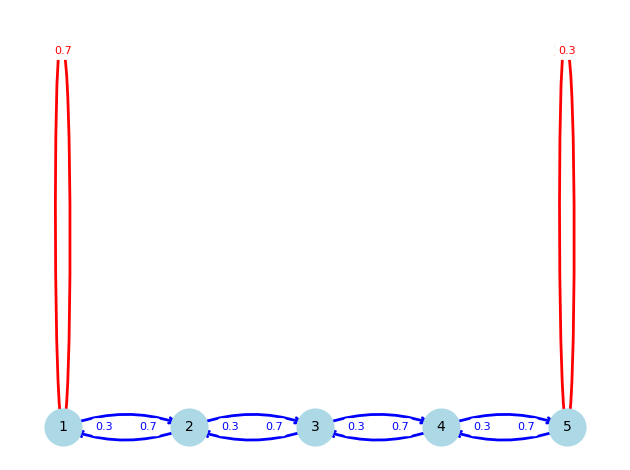

In [7]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.MultiDiGraph()
n: int = 5
p: float = 0.3
P: np.array = build_p_matrices(chain=1, p_values=[p], n_values=[n])[0]
states: list[int] = [i for i in range(1, n + 1)]

print(P)

# Arrange nodes linearly on the x-axis
pos = {state: (state, 0) for state in states}
G.add_nodes_from(states)

# Separate self-loops and forward edges for different styling
self_loops = []
forward_edges = []
self_loop_labels = {}
forward_edge_labels = {}

for i in range(n):
    for j in range(n):
        if P[i][j] != 0:
            edge = (i + 1, j + 1)
            if i == j:  # Self-loop
                self_loops.append(edge)
                self_loop_labels[edge] = f'{P[i][j]:.1f}'
            else:  # Forward edge
                forward_edges.append(edge)
                forward_edge_labels[edge] = f'{P[i][j]:.1f}'

G.add_edges_from(self_loops)
G.add_edges_from(forward_edges)

print("Self loops:", self_loops)
print("Forward edges:", forward_edges)
print("Self loop labels:", self_loop_labels)
print("Forward edge labels:", forward_edge_labels)

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=700)

# Draw self-loops with larger arc radius (above the nodes)
if self_loops:
    nx.draw_networkx_edges(G, pos,
                          edgelist=self_loops,
                          arrowstyle="->",
                          arrowsize=15,
                          edge_color='red',
                          width=2,
                          connectionstyle="arc3,rad=0.8")

# Draw forward edges with smaller arc radius (below the nodes)
if forward_edges:
    nx.draw_networkx_edges(G, pos,
                          edgelist=forward_edges,
                          arrowstyle="->",
                          arrowsize=10,
                          edge_color='blue',
                          width=2,
                          connectionstyle="arc3,rad=-0.2")

# Draw node labels
nx.draw_networkx_labels(G, pos, font_size=10, font_color='black')

# Draw edge labels with different positioning
if self_loop_labels:
    # Position self-loop labels above the nodes
    nx.draw_networkx_edge_labels(G, pos,
                                self_loop_labels,
                                font_size=8,
                                font_color='red',
                                label_pos=0.5)

if forward_edge_labels:
    # Position forward edge labels on the edges (slightly below)
    nx.draw_networkx_edge_labels(G, pos,
                                forward_edge_labels,
                                font_size=8,
                                font_color='blue',
                                label_pos=0.3)

plt.axis('off')
plt.tight_layout()
plt.show()

### Cadena 2

A continuación, implementamos una cadena de Markov con dos comunidades o dos “pozos” de estados, unidas por un cuello de botella que controla la mezcla entre ellas.

Normalmente, la cadena permanece dentro de cada ciclo, pues solo puede saltar de un ciclo al otro mediante una “puerta angosta” entre los estados $n$ y $n+1$, con probabilidad pequeña $2 \epsilon$.

#### Descripción de la cadena

Espacio de estados:
La cadena tiene $2n$ estados, numerados $1,2, ..., n, n+1, ..., 2n$.
Los estados están organizados en dos ciclos: Uno con los primeros $n$ estados y otro con los siguientes $n$ estados.

*Dinámica en el primer ciclo ($\mathit{1 \to n}$)*:

Desde un estado $i$ (con $1< 𝑖 < n$) se puede ir:
- A $i+1$ con probabilidad $p$.
- A $i-1$ con probabilidad $q=1-p$.

En el estado $n$:
- Se va a $n-1$ con probabilidad $q-\epsilon$.
- Va hacia 1 con probabilidad $p-\epsilon$.

*Dinámica en el segundo ciclo ($\mathit{n + 1 \to 2n}$)*:

Funciona igual que el primero, pero en $n + 1$:
- Va hacia $n + 2$ con probabilidad $p-\epsilon$.
- Hacia $2n$ con probabilidad $q-\epsilon$.

*Puente entre los dos ciclos*:

El estado $n$ y el estado $n + 1$ son los que conectan ambos ciclos:
- De $n \to n + 1$ con probabilidad $2 \epsilon$.
- De $n + 1 \to n$ con probabilidad $2 \epsilon$.

##### Irreducibilidad y aperiocidad

La Cadena 2 es irreducible porque:

ε > 0: Hay probabilidad positiva de saltar entre comunidades y por tanto, desde cualquier estado puedo llegar a cualquier otro:

Dentro de una comunidad: Por la estructura cíclica (p, q > 0)

Entre comunidades: A través del puente con probabilidad 2ε

La Cadena 2 es PERIÓDICA (periodo = 3) porque hay una structura cíclica de cada comunidad en torno al regreso:

Comunidad 1: S1 → S2 → S3 → S1 (ciclo de longitud 3)

Comunidad 2: S4 → S5 → S6 → S4 (ciclo de longitud 3)

Desde cualquier estado, el mcd de las longitudes de ciclos es 3

Ejemplo: Desde S1 puedo volver a S1 en:

3 pasos: S1 → S2 → S3 → S1

6 pasos: S1 → S2 → S3 → S1 → S2 → S3 → S1

mcd(3, 6, ...) = 3

Utilizando la función `build_p_matrices` definida en la sección de *Funciones extra*, se puede obtener la matriz de transición para la cadena 2.

In [88]:
# Ejemplo de prueba
n_test = 3
p_test = 0.6
epsilon_test = 0.05

P_community = build_p_matrices(2, [n_test], [p_test], [epsilon_test])[0]
print("Matriz de transición de la cadena de dos comunidades:")
print(P_community)
print("\nSuma de filas:", P_community.sum(axis=1))

Matriz de transición de la cadena de dos comunidades:
[[0.   0.6  0.4  0.   0.   0.  ]
 [0.4  0.   0.6  0.   0.   0.  ]
 [0.55 0.35 0.   0.1  0.   0.  ]
 [0.   0.   0.1  0.   0.55 0.35]
 [0.   0.   0.   0.4  0.   0.6 ]
 [0.   0.   0.   0.6  0.4  0.  ]]

Suma de filas: [1. 1. 1. 1. 1. 1.]


#### Interpretación

*Primera comunidad*

Desde el estado $3$ se va a:
- Estado 2 con prob. 0.35,
- Estado 1 con prob. 0.55,
- Estado 4 (puente hacia la otra comunidad) con prob. 0.10.

*Segunda comunidad*

Desde estado $4$ a $3$ con $0.10$, a $5$ con $0.55$, a $6$ con $0.35$.

Cada fila suma exactamente $1.0$

Aquí una visualización de la cadena del ejemplo:


![Description of image](CM2Pozos.jpeg)


## Métodos para encontrar la distribución estacionaria

Ya que las cadenas presentadas anteriormente son irreducibles y aperiódicas, su distribución estacionaria existe y es única. Ahora, se calculará usando dos métodos diferentes, comparando la eficiencia temporal de estos:

### Hallando los autovectores de $P^\intercal$

Se sabe que una distribución $\pi$ se le llama estacionaria si
$$\pi P = \pi$$
o equivalentemente
$$P^{\intercal} \pi^{\intercal} = \pi^{\intercal}$$
por lo tanto, hallar $\pi$ se reduce a hallar un autovector de la matriz $P^{\intercal}$.

Dicho autovector se hallará utilizando las librerías `numpy` y `scipy`, las más populares en cálculo científico, y `simpy`, una librería de cálculo simbólico. Normalmente, bastaría con la primera, mas sin embargo, como explican en [esta pregunta en StackOverflow](https://stackoverflow.com/questions/6684238/whats-the-fastest-way-to-find-eigenvalues-vectors-in-python), `scipy` identifica diversos tipos de matrices y ajusta los cálculos de los autovectores de acuerdo al mejor algoritmo que aplique para cada tipo. Por otro lado, `simpy` seguramente será la más lenta de las tres, pero proverá una buena indicación de qué tanto tardaría el proceso si se busca exactitud en la solución (o precisión casi infinita).

Ahora, independientemente de qué librería o lenguaje se utilice, es estándar retornar los autovectores normalizados (bajo la norma euclídea estándar). Por lo tanto, se deberá hacer un cálculo extra para asegurar que al menos uno de los autovectores $v$ cumpla que $\sum_{i = 1}^{n}v_i = 1$ y que $0 \leq v_i \leq 1$ para todo $i \in \{1, ..., n\}$. Este consiste en computar un escalar $x \in \mathbb{R}$ tal que

$$\frac{\sum_{i = 1}^n v_i}{x} = 1 \iff x = \sum_{i = 1}^n v_i$$

y dividir a cada componente del vector $v$ para obtener un candidato a distribución estacionaria $v' = (\frac{v_1}{x}, \frac{v_2}{x}, ..., \frac{v_n}{x})$.

Por último, es relevante destacar que según la documentación de numpy, la complejidad computacional de hallar autovectores en una matriz $n$ x $n$ es de $O(n^3)$.

#### Cadena 1

In [89]:
matrices = build_p_matrices(chain=1, n_values=n_values, p_values=p_values)

In [90]:
#!Consider creating an object that stores all the matrices with n states to have a better reference when printing

In [91]:
import scipy

def stationary_candidates_scipy(matrix) -> list[np.array]:
    # print("   Using scipy...")
    candidates: list[np.array] = []
    # print(f"Candidates for the matrix")
    eigen_values, eigen_vectors = scipy.linalg.eig(matrix.T)
    for i, (eigen_values, eigen_vectors) in enumerate(zip(eigen_values, eigen_vectors.T)):
        #*If it is the stationary distribution, then it has an associated eigen value
        #*of 1, since it is the solution to P \pi = \pi
        if np.isclose(eigen_values, 1.0, atol=1e-10):
            if np.allclose(eigen_vectors.imag, 0, atol=1e-10):
                real_vec = eigen_vectors.real
                #*Avoid division by zero
                if real_vec.sum() != 0:
                    normalized_vec = real_vec / real_vec.sum()
                    candidates.append(normalized_vec)
    return get_distributions(candidates)


In [92]:
for matrix in matrices:
    print_distributions(stationary_candidates_scipy(matrix))


Stationary distribution of the matrix 1th
[0.9 0.1]
Stationary distribution of the matrix 1th
[0.8 0.2]
Stationary distribution of the matrix 1th
[0.7 0.3]
Stationary distribution of the matrix 1th
[0.6 0.4]
Stationary distribution of the matrix 1th
[0.5 0.5]
Stationary distribution of the matrix 1th
[0.4 0.6]
Stationary distribution of the matrix 1th
[0.3 0.7]
Stationary distribution of the matrix 1th
[0.2 0.8]
Stationary distribution of the matrix 1th
[0.1 0.9]
Stationary distribution of the matrix 1th
[0.89010989 0.0989011  0.01098901]
Stationary distribution of the matrix 1th
[0.76190476 0.19047619 0.04761905]
Stationary distribution of the matrix 1th
[0.62025316 0.26582278 0.11392405]
Stationary distribution of the matrix 1th
[0.47368421 0.31578947 0.21052632]
Stationary distribution of the matrix 1th
[0.33333333 0.33333333 0.33333333]
Stationary distribution of the matrix 1th
[0.21052632 0.31578947 0.47368421]
Stationary distribution of the matrix 1th
[0.11392405 0.26582278 0.620

In [93]:
def stationary_candidates_numpy(matrix):
    candidates: list[np.array] = []
    # print(f"Candidates for {i}th matrix")
    eigen_values, eigen_vectors = np.linalg.eig(matrix.T)
    for i, (eigen_values, eigen_vectors) in enumerate(zip(eigen_values, eigen_vectors.T)):
        #*See explanation in stationary_candidates_scipy
        if np.isclose(eigen_values, 1.0, atol=1e-10):
            if np.allclose(eigen_vectors.imag, 0, atol=1e-10):
                real_vec = eigen_vectors.real
                #*Avoid division by zero
                if real_vec.sum() != 0:
                    normalized_vec = real_vec / real_vec.sum()
                    candidates.append(normalized_vec)
    # print(candidates)

    return get_distributions(candidates)



In [94]:
for matrix in matrices:
    print_distributions(stationary_candidates_numpy(matrix))

Stationary distribution of the matrix 1th
[0.9 0.1]
Stationary distribution of the matrix 1th
[0.8 0.2]
Stationary distribution of the matrix 1th
[0.7 0.3]
Stationary distribution of the matrix 1th
[0.6 0.4]
Stationary distribution of the matrix 1th
[0.5 0.5]
Stationary distribution of the matrix 1th
[0.4 0.6]
Stationary distribution of the matrix 1th
[0.3 0.7]
Stationary distribution of the matrix 1th
[0.2 0.8]
Stationary distribution of the matrix 1th
[0.1 0.9]
Stationary distribution of the matrix 1th
[0.89010989 0.0989011  0.01098901]
Stationary distribution of the matrix 1th
[0.76190476 0.19047619 0.04761905]
Stationary distribution of the matrix 1th
[0.62025316 0.26582278 0.11392405]
Stationary distribution of the matrix 1th
[0.47368421 0.31578947 0.21052632]
Stationary distribution of the matrix 1th
[0.33333333 0.33333333 0.33333333]
Stationary distribution of the matrix 1th
[0.21052632 0.31578947 0.47368421]
Stationary distribution of the matrix 1th
[0.11392405 0.26582278 0.620

*Análisis de la cadena 1*

Simétrica salvo por la primera y la n, n-ésima entrada implica que las entradas de la distribución estacionaria serán iguales?

#### Cadena 2

In [95]:
pi_scipy = stationary_candidates_scipy(P_community)[0]
print("Distribución estacionaria con NumPy:")
for i, prob in enumerate(pi_scipy):
    print(f"Estado {i+1}: {prob:.6f}")

print(f"\nSuma: {pi_scipy.sum():.10f}")

# Verificar que es estacionaria: πP ≈ π
piP = pi_scipy @ P_community
print(f"\nVerificación (||πP - π||): {np.linalg.norm(piP - pi_scipy):.10e}")



Distribución estacionaria con NumPy:
Estado 1: 0.161972
Estado 2: 0.159624
Estado 3: 0.178404
Estado 4: 0.178404
Estado 5: 0.161972
Estado 6: 0.159624

Suma: 1.0000000000

Verificación (||πP - π||): 1.6420419977e-16


In [96]:
pi_numpy = stationary_candidates_numpy(P_community)[0]
print("Distribución estacionaria con NumPy:")
for i, prob in enumerate(pi_numpy):
    print(f"Estado {i+1}: {prob:.6f}")

print(f"\nSuma: {pi_numpy.sum():.10f}")

# Verificar que es estacionaria: πP ≈ π
piP = pi_numpy @ P_community
print(f"\nVerificación (||πP - π||): {np.linalg.norm(piP - pi_numpy):.10e}")

Distribución estacionaria con NumPy:
Estado 1: 0.161972
Estado 2: 0.159624
Estado 3: 0.178404
Estado 4: 0.178404
Estado 5: 0.161972
Estado 6: 0.159624

Suma: 1.0000000000

Verificación (||πP - π||): 1.6420419977e-16


In [97]:
print("Is NumPy's distribution the same as SciPy's?", np.allclose(pi_numpy, pi_scipy, atol=1e-6))

Is NumPy's distribution the same as SciPy's? True


*Análisis esperado para la Cadena 2*

Dado que la cadena tiene simetría entre las dos comunidades (mismo tamaño $n=3$, mismas probabilidades), pero con un cuello de botella ($\epsilon=0.05$), esperaríamos:
- Simetría aproximada: $\pi(S_1) ≈ \pi(S_4), \pi(S_2) ≈ \pi(S_5), \pi(S_3) ≈ \pi(S_6)$
- Efecto del cuello de botella: Los estados cerca del puente ($S_3$ y $S_4$) podrían tener probabilidades ligeramente diferentes.

Suma total $= 1$: Verificación crucial

### Usando la fórmula de recurrencia

Ya que las cadenas trabajadas son homogéneas, aperiódicas e irreducibles, la distribución estacionaria es única por el teorema 5.3 visto en clase. Además, por ejercicio ... (realizar ejercicio), se sabe que esta distribución tendrá la forma
$$\pi = \left(\frac{1}{\mathbb{E}_1[T_1^+]}, \frac{1}{\mathbb{E}_2[T_2^+]}, ..., \frac{1}{\mathbb{E}_n[T_n^+]}\right) = \left(\frac{1}{r_1}, \frac{1}{r_2}, ..., \frac{1}{r_n}\right)$$
Además, para todo $i \in \{1, ..., n\}$, $r_i := \mathbb{E}_i[T_i^+] = 1 + \sum_{j \in S}P_{ij} t_{j, \{i\}}$, y como $t_{i, \{i\}} := \mathbb{E}_i[T_i] = 0$ (pues si $X_0 = i$, ya se está en el estado al que se quería retornar), se puede descartar el caso en que $j = i$. Luego, 
$$r_i = \mathbb{E}_i[T_i^+] = 1 + \sum_{j \in S, j \neq i}P_{ij} t_{j, \{i\}} = (\pi_i)^{-1}$$
donde $\pi$ es la distribución estacionaria de cada cadena, $P$ es la matriz de transición de la cadena, y $t_{j, \{i\}} := \mathbb{E}_i[T_{\{i\}}] = 1 + \sum_{j \in S^t} P_{ij} t_{j, \{i\}}$ el tiempo medio de llegada al estado $i$ desde el estado $j$.

La forma de calcular los tiempos medios de llegada a un estado desde otro es recurrentemente, es decir, se va formando un sistema de ecuaciones con los $i, j \in S$ necesarios para poder calcular los $t_{j, \{i\}}$ requeridos. Este cálculo se realizará a continuación representando dicho sistema como una matriz que va creciendo a medida en que se requiren más $t_{j, \{i\}}$.

In [98]:
matrices = build_p_matrices(chain=1, p_values=[n/10 for n in range (1, 10)], n_values=[n for n in range(2, 10)])

#### Sin recursión (Juanse)

Si las cadenas tienen $n$ nodos, entonces habrán $n^2$ tiempos de retorno, ya que hay $n.n$ tuplas posibles. Notemos que para calcular un $t_{i,j}$, los estados de los que este depende serán: $t_{0,j} , t_{1,j} , ... , t_{n-1,j}$ por la fórmula de recurrencia que se vio en clase. Es decir, en vez de resolver un sistema de $n^2$ x $n^2$ entradas para hallar cada $t_{i,j}$, basta con hallar $n$ sistemas $n$ x $n$ para determinar los $t_{i,0}$ , $t_{i,1}$ , ... , $t_{i,n-1}$ para todo $0 \leq i \leq n-1$. Esto reduce la complejidad de gran manera, ya que resolver $n$ sistemas $n$ x $n$ toma $O(n^4)$ ya que resolver un sistema de $n$ x $n$ usando Gauss Jordan toma $O(n^3)$ operaciones.

Complejidad total: $O(n^4)$

In [99]:
def t_ij_Matrix(P_matrix: np.array) -> np.array:
  """
  The main idea is to calculate all the states t_{i,j} but keeping fixed j and then iterating over i, since 
  no matter for what i we need to calculate t_{i,j}, the recurrence formula requires j fixed and all the posible
  i's. For example,
  t_0,0 = 0
  t_1,0 = 1 + P_1,0 . t_0,0 + P_1,1 . t_1,0 + P_1,2 . t_2,0  <->  (1 - P_1,1) . t_1,0    -    P_1,2 . t_2,0 = 1
  t_2,0 = 1 + P_2,0 . t_0,0 + P_2,1 . t_1,0 + P_2,2 . t_2,0  <->      - P_2,1 . t_1,0 + (1 - P_2,2) . t_2,0 = 1
  notice that to calculate t_{1, 0} or t_{2, 0}, we require the value of the other t_{k, 0} (since we know
  t_{0, 0} = 0). Generalizing, we would only require an (n-1)x(n-1) system of equations to calculate each
  t_{i, j}.
  """
  t_ij_M = []
  rows = P_matrix.shape[0]


  for j in range(0,rows):
    valid_states = [i for i in range(rows) if i != j]

    n = rows - 1
    submatrix = np.zeros((n, n), dtype=float)
    ones = np.ones(n, dtype=float)

    for r, i in enumerate(valid_states):
        for c, d in enumerate(valid_states):
            if i == d:
                submatrix[r, c] = 1.0 - P_matrix[i, i] # Notice that we can always factor the ti,j that we want to calculate. See in the example that t_1,0 is at the left and right side of the equation.
            else:
                submatrix[r, c] = - P_matrix[i, d] # Else, the matrix entrance will be the probability taken to the left side of the equation

    sol_vector = np.linalg.solve(submatrix, ones)
    t = np.zeros(rows, dtype=float)
    for k, s in enumerate(valid_states):
        t[s] = sol_vector[k]
    t[j] = 0.0
    t_ij_M.append(t)

  return np.array(t_ij_M)


def get_stationary_distr_rf1(P_matrix: np.array) -> np.array:
  """
  Once we have all the values of t_ij, we can simply replace in the equations of the r_i, take the inverses and get the stationary distribution.
  """
  t_ij_M = t_ij_Matrix(P_matrix)
  stationary_distribution = []
  for i in range(0, P_matrix.shape[0]):
    r_i = 1
    for j in range(0, P_matrix.shape[1]):
      r_i += P_matrix[i][j]*t_ij_M[i][j]
    stationary_distribution.append(1/r_i)
  return np.array(stationary_distribution)

In [100]:
matrix1 = np.array(
    [[1/2, 1/2, 0],
     [0, 1/3, 2/3],
     [1/2, 1/2, 0]]
)

matrix2 = np.array(
    [[0.9, 0.1],
     [0.5, 0.5]]
    )

matrix3 = np.array(
    [
 [0.0, 0.5, 0.0, 0.5],
 [0.5, 0.0, 0.5, 0.0],
 [0.0, 0.5, 0.0, 0.5],
 [0.5, 0.0, 0.5, 0.0]
]
)

P: np.array = np.array(
    [[1/4, 1/4, 1/4, 1/4],
     [1/3, 1/3, 1/3, 0],
     [1/3, 1/3, 1/6, 1/6],
     [1/5, 2/5, 1/5, 1/5]]
)


t_ij_Matrix(matrix1)
get_stationary_distr_rf1(matrix1)

t_ij_Matrix(matrix2)
get_stationary_distr_rf1(matrix2)

t_ij_Matrix(matrix3)
get_stationary_distr_rf1(matrix3)

t_ij_Matrix(P)
get_stationary_distr_rf1(P)

array([0.29015544, 0.31865285, 0.24870466, 0.14248705])

#### Sin recursión (Sara)

In [101]:
def get_stationary_distr_rf2(P):
    """
    Calcula la distribución estacionaria usando el método de recurrencias:
    π_i = 1 / E_i[T_i^+]
    donde E_i[T_i^+] = 1 + Σ_{j≠i} P_ij * t_{j,{i}}
    y t_{j,{i}} se calcula resolviendo un sistema de ecuaciones
    """
    n = P.shape[0]
    pi = np.zeros(n)
    
    for target_state in range(n):
        # Para cada estado i, calculamos r_i = E_i[T_i^+]
        r_i = compute_mean_return_time(P, target_state)
        pi[target_state] = 1.0 / r_i if r_i > 0 else 0.0  
    # Normalizar por si hay pequeñas imprecisiones numéricas
    pi = pi / pi.sum()
    return pi

def compute_mean_return_time(P, target_state):
    """
    Calcula E_i[T_i^+] para un estado target_state dado
    """
    n = P.shape[0]
    
    # Estados relevantes: todos excepto el target_state
    relevant_states = [i for i in range(n) if i != target_state]
    
    # Construir el sistema de ecuaciones para t_{j,{i}} = 1 + Σ_{k≠i} P_jk * t_{k,{i}}
    
    # Matriz del sistema: A * t = b
    A = np.zeros((len(relevant_states), len(relevant_states)))
    b = np.ones(len(relevant_states))
    
    # Mapeo de indices globales a indices locales
    state_to_index = {state: idx for idx, state in enumerate(relevant_states)}
    
    for idx_j, j in enumerate(relevant_states): #idx abreviacion para index
        for k in range(n):
            if k == target_state:
                # Cuando k = i, t_{k,{i}} = 0 (ya estamos en el estado objetivo)
                continue
            elif k == j:
                # Coeficiente para t_{j,{i}}
                A[idx_j, idx_j] -= P[j, k]
            else:
                # Coeficiente para t_{k,{i}} donde k diferente a j
                if k in state_to_index:
                    A[idx_j, state_to_index[k]] -= P[j, k]
    
    # La ecuación es: t_{j,{i}} - Σ P_jk * t_{k,{i}} = 1
    # Por lo tanto: A = I - P_reduced, pero ajustando diagonales
    for idx_j, j in enumerate(relevant_states):
        A[idx_j, idx_j] += 1.0
    
    # Resolver el sistema lineal
    try:
        t_values = np.linalg.solve(A, b)
    except np.linalg.LinAlgError:
        # Usar mínimos cuadrados si el sistema es singular
        t_values = np.linalg.lstsq(A, b, rcond=None)[0]
    
    # Calcular r_i = E_i[T_i^+] = 1 + Σ_{j≠i} P_ij * t_{j,{i}}
    r_i = 1.0
    for j in range(n):
        if j != target_state:
            if j in state_to_index:
                r_i += P[target_state, j] * t_values[state_to_index[j]]
    
    return r_i
      

In [102]:
# Calcular distribución estacionaria por recurrencias para la Cadena 2
print("=== MÉTODO DE RECURRENCIAS - CADENA 2 ===")

pi_recurrence = get_stationary_distr_rf2(P_community)

print("Distribución estacionaria (recurrencias):")
for i, prob in enumerate(pi_recurrence):
    print(f"Estado {i+1}: {prob:.6f}")

print(f"Suma: {pi_recurrence.sum():.10f}")

# Comparar con el método de autovectores
print(f"\n=== COMPARACIÓN DE MÉTODOS ===")
print("Diferencia ||π_recurrence - π_scipy||:", np.linalg.norm(pi_recurrence - pi_scipy))

# Verificar la propiedad πP = π
piP_recurrence = pi_recurrence @ P_community
error_recurrence = np.linalg.norm(piP_recurrence - pi_recurrence)
print(f"Error ||πP - π|| (recurrencias): {error_recurrence:.10e}")

=== MÉTODO DE RECURRENCIAS - CADENA 2 ===
Distribución estacionaria (recurrencias):
Estado 1: 0.161972
Estado 2: 0.159624
Estado 3: 0.178404
Estado 4: 0.178404
Estado 5: 0.161972
Estado 6: 0.159624
Suma: 1.0000000000

=== COMPARACIÓN DE MÉTODOS ===
Diferencia ||π_recurrence - π_scipy||: 1.841096603147574e-15
Error ||πP - π|| (recurrencias): 1.3877787808e-16


#### Con recursión (Santiago)

In [103]:
import numpy as np

def generate_t_matrix(P:np.array) -> np.array:
    """
    Returns a n^2 x n^2 matrix T whose entry
    (i, j) = (q_1 n + r_1, q_2 n + r_2) (where q_i, r_i are obtained using
    the division algorithm)
    - is 0 if i \not \in \{1, 2 + n, ..., i + (i-1)n, ..., n + n\},
    i.e., it doesn't correspond to a mean return time in the form
    t_{k, j}, where k is any state of the chain.
    - is P_{r_1, r_2}, a.k.a., P_{i, k}, otherwise.
    """
    n: int = P.shape[0]
    T: np.array = np.zeros(shape=(n*n, n*n))
    # print(T)
    #!Consider addin a rule for t_i,i to be  0
    #*Filling the non-zero values of t(i, j)
    for i in range(n):
        for j in range(n):
            if j == i:
                j += 1
                continue
            n_mult: int = 0 #*n multiplier
            for k in range(n):
                #*Since k starts from 0, there is no need to multiply n by k - 1
                k_val: int = i + j*n
                j_val: int = j + n*k
                i_val: int = i
                # print(i, k, P[i][k], (i*n + j, j + n*k))
                T[i*n + j, j + n*k] = P[i][k]
    for i in range(n*n):
        T[i][i] -= 1
    for i in range(n):
        T[i*(n+1)][i*(n+1)] = 0

    return T

def pretty_print(M: np.array, h_indices: list[str] = None, v_indices: list[str] = None) -> None:
    if h_indices is None:
        h_indices = [i for i in range(M.shape[1])]
    if v_indices is None:
        v_indices = [i for i in range(M.shape[0])]

    n_rows, n_cols = M.shape
    # Determine column width based on the longest h_indices string (at least 7)
    col_width = max(8, max(len(str(idx)) for idx in h_indices) + 1)
    # Print column indices
    print(" " * (col_width + 1), end="")
    for index in h_indices:
        print(f"{index:>{col_width}}", end="")
    print()
    # Print each row with its index
    for row in range(n_rows):
        print(f"{v_indices[row]:>3} |", end="")
        for col in range(n_cols):
            print(f"{M[row, col]:{col_width}.2f}", end="")
        print()
    
def generate_index_labels(prefix: str, n: int, m: int) -> list[str]:
    """
    Returns a list of strings in the format 'prefix(i, j)' for i in range(1, n + 1),
    j in range(1, m+1), listed in lexicographical order.
    """
    return [f"{prefix}({i}, {j})" for i in range(1, n+1) for j in range(1, m+1)]

def get_necessary_tijs(i: int, j: int, n: int, T: np.array, syst: list[np.array], bool_map: list[list[bool]]) -> int:
    if i == j:
        return 0
    map: list[list[bool]] = bool_map
    map[i][j] = 1
    syst.append(T[n*i + j])
    # print("Bool map", bool_map)
    # print("System of equations", syst)
    for k in range(n):
        if k == j:
            pass
        elif bool_map[k][j] == 0:
            syst, map = get_necessary_tijs(k, j, n, T, syst, map)
    return syst, map

def chop_system(S: np.array, n: int) -> np.array:
    chopped: np.array = S
    #*Remove the t_{i, i} entries
    for i in range(n):
        #*Although we are chopping the i*(n+1)-th column of the original
        #*system, every deletion subtracts 1 to the number of columns,
        #*so it ends up being the i*n-th column
        chopped = np.delete(chopped, i*n, axis=1)
    #*Remove columns that are all zeros (not necessary in the system)
    chopped = chopped[:, ~np.all(chopped == 0, axis=0)]
    return chopped

def solve_system(S: np.array) -> np.array:
    solution: np.array = np.linalg.solve(S, -np.ones(S.shape[0]))
    solution = solution
    return solution

def get_stationary_distr_rf3(P: np.array) -> np.array:
    """
    Function to calculate the stationary distribution of a Markov chain
    with transition matrix `P` using the recurrence formulas
    """
    if P.shape[0] != P.shape[1]:
        raise ValueError("Matrix must be squared. Got matrix with shape", P.shape)

    n: int = P.shape[0]
    r: np.array = np.zeros(n)
    T: np.array = generate_t_matrix(P)
    #*Calculate each r_i
    for i in range(n):
        #!Bold assumption that requires proof: to calculate a t_(i, j), the system and its subsystems will only have t_(k, j), which actually sounds kind of obvious once you look at the formula, never mind. May be worth writing though
        if i == 0:
            syst_matrix, _ = get_necessary_tijs(1, i, n, T, [], [[0 for k in range(n)] for l in range(n)])
        else:
            syst_matrix, _ = get_necessary_tijs(0, i, n, T, [], [[0 for k in range(n)] for l in range(n)])
        syst_chopped = chop_system(syst_matrix, n)
        #*Vector containing the value of each t_(j, i) necessary to calculate ri
        t_vector: np.array = solve_system(syst_chopped)
        t_vector = np.insert(t_vector, i, 0)
        for j in range(n):
            r[i] += P[i][j] * t_vector[j]
        r[i] += 1

    r = 1/r

    return r


<>:8: SyntaxWarning: invalid escape sequence '\i'
<>:8: SyntaxWarning: invalid escape sequence '\i'
/tmp/ipykernel_4843/178164655.py:8: SyntaxWarning: invalid escape sequence '\i'
  - is 0 if i \not \in \{1, 2 + n, ..., i + (i-1)n, ..., n + n\},


In [104]:
P: np.array = np.array(
    [[1/4, 1/4, 1/2],
     [1/3, 1/3, 1/3],
     [1/2, 1/3, 1/6]]
)
P: np.array = np.array(
    [[1/4, 1/4, 1/4, 1/4],
     [1/3, 1/3, 1/3, 0],
     [1/3, 1/3, 1/6, 1/6],
     [1/5, 2/5, 1/5, 1/5]]
)
n: int = P.shape[0]
bool_map = [[0 for j in range(n)] for i in range(n)]
T: np.array = generate_t_matrix(P)
i: int = 1
j: int = 0
syst, map = get_necessary_tijs(i, j, P.shape[0], T, [], bool_map)
syst_matrix = np.vstack(syst)

indices: list[str] = generate_index_labels("T", P.shape[0], P.shape[1])
pretty_print(T, indices, indices)

# print(syst_matrix)
print("Final system of equations:")
chopped: np.array = chop_system(syst_matrix, n)
print(chopped)

solution: np.array = solve_system(chopped)
print("Solution vector:", solution)
result = chopped @ solution
print(result)
print(f"t_({i+1}, {j+1}) = {solution[0]}")

print("Stationary distribution:")
r_solutions = get_stationary_distr_rf3(P)
print(r_solutions)
print("Is the sum of the distribution 1?:", r_solutions.sum() == 1.0)
npy_solutions = get_distributions(stationary_candidates_scipy(P))[0]
spy_solutions = get_distributions(stationary_candidates_scipy(P))[0]
print("Is it the same as SciPy's and NumPy's?",
    np.allclose(r_solutions, npy_solutions, atol=1e-6),
    np.allclose(r_solutions, spy_solutions, atol=1e-6))

          T(1, 1) T(1, 2) T(1, 3) T(1, 4) T(2, 1) T(2, 2) T(2, 3) T(2, 4) T(3, 1) T(3, 2) T(3, 3) T(3, 4) T(4, 1) T(4, 2) T(4, 3) T(4, 4)
T(1, 1) |    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00
T(1, 2) |    0.00   -0.75    0.00    0.00    0.00    0.25    0.00    0.00    0.00    0.25    0.00    0.00    0.00    0.25    0.00    0.00
T(1, 3) |    0.00    0.00   -0.75    0.00    0.00    0.00    0.25    0.00    0.00    0.00    0.25    0.00    0.00    0.00    0.25    0.00
T(1, 4) |    0.00    0.00    0.00   -0.75    0.00    0.00    0.00    0.25    0.00    0.00    0.00    0.25    0.00    0.00    0.00    0.25
T(2, 1) |    0.33    0.00    0.00    0.00   -0.67    0.00    0.00    0.00    0.33    0.00    0.00    0.00    0.00    0.00    0.00    0.00
T(2, 2) |    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00
T(2, 3) |    0.00    0.00    0.33 

**Considerar el ejemplo en el que la distr es (1, 0, 0, 0, 0) como argumento a favor de los autovectores**

## Análisis de complejidad temporal

Cada función será llamada usando el wrapper `timed_exec`, que medirá el tiempo en que se demoró en ejecutar la función enviada como argumento.

In [105]:
import time

def timed_run(func, *args, **kwargs):
    start = time.perf_counter()
    func(*args, **kwargs)
    end = time.perf_counter()
    elapsed = end - start
    return elapsed

Cada método se ejecutará con todas las posibles combinaciones de los [parámetros iniciales](#param) definidos al inicio del notebook, y su tiempo de ejecución se guardará en un DataFrame que se analizará a continuación.

In [112]:
import pandas as pd


def get_results(matrices: list[np.array], n_values: list[int], p_values: list[float], e_values: list[float] = None, chain: int = 1) -> pd.DataFrame:
    if chain == 1:
        results: pd.DataFrame = pd.DataFrame(columns=["n", "p", "NumPy", "SciPy", "Recurrence1", "Recurrence2", "Recurrence3"])
        i: int = 0
        for n in n_values:
            for p in p_values:
                # print(matrices[i])
                elapsed_time_numpy: float = timed_run(stationary_candidates_numpy, matrices[i])
                elapsed_time_scipy: float = timed_run(stationary_candidates_scipy, matrices[i])
                try:
                    elapsed_time_recurrence1: float = timed_run(get_stationary_distr_rf1, matrices[i])
                    elapsed_time_recurrence2: float = timed_run(get_stationary_distr_rf2, matrices[i])
                    elapsed_time_recurrence3: float = timed_run(get_stationary_distr_rf3, matrices[i])
                except BaseException as e:
                    print(e)
                    elapsed_time_recurrence3 = np.nan
                results.loc[len(results)] = {"n": n, "p": p, "NumPy": elapsed_time_numpy, "SciPy": elapsed_time_scipy, "Recurrence1": elapsed_time_recurrence1, "Recurrence2": elapsed_time_recurrence2, "Recurrence3": elapsed_time_recurrence3}
                i += 1
    elif chain == 2:
        if e_values is None:
            e_values = [n/100 for n in range(10)]
        results: pd.DataFrame = pd.DataFrame(columns=["n", "p", "e", "NumPy", "SciPy", "Recurrence1", "Recurrence2", "Recurrence3"])
        i: int = 0
        for n in n_values:
            for p in p_values:
                for e in e_values:
                    # print(matrices[i])
                    elapsed_time_numpy: float = timed_run(stationary_candidates_numpy, matrices[i])
                    elapsed_time_scipy: float = timed_run(stationary_candidates_scipy, matrices[i])
                    try:
                        elapsed_time_recurrence1: float = timed_run(get_stationary_distr_rf1, matrices[i])
                        elapsed_time_recurrence2: float = timed_run(get_stationary_distr_rf2, matrices[i])
                        elapsed_time_recurrence3: float = timed_run(get_stationary_distr_rf3, matrices[i])
                    except BaseException as error:
                        print(error)
                        elapsed_time_recurrence3 = np.nan
                    results.loc[len(results)] = {"n": n, "p": p, "e": e, "NumPy": elapsed_time_numpy, "SciPy": elapsed_time_scipy, "Recurrence1": elapsed_time_recurrence1, "Recurrence2": elapsed_time_recurrence2, "Recurrence3": elapsed_time_recurrence3}
                    i += 1

    return results

### Gráficas

A continuación se presenta el código que se utilizará para graficar los tiempos de ejecución de los métodos antes presentados usando diversas cadenas.

In [135]:
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

def plot_time_execution(times_df: pd.DataFrame, chain: int = 1, x_axis: str = 'n', n_value: int = None, p_value: float = None, e_value: float = None) -> None:
    if chain == 1:
        if x_axis == "n":
            fig, ax = plt.subplots(figsize=(18, 6))
            try:
                times_df_copy = times_df.sort_values(by='n', ascending=True)
                if p_value is not None:
                    times_df_copy = times_df_copy[times_df_copy['p'] == p_value]
                else:
                    print(f"Invalid parameter: p - {p_value}")
                ax.plot(times_df_copy['n'], times_df_copy['NumPy'], lw=1.6, color='green', label='Autovectores (NumPy)')
                ax.plot(times_df_copy['n'], times_df_copy['SciPy'], lw=1.6, color='red', label='Autovectores (SciPy)')
                ax.plot(times_df_copy['n'], times_df_copy['Recurrence1'], lw=1.6, color='#003366', label='Fórmula de recurrencia 1')  # dark blue
                ax.plot(times_df_copy['n'], times_df_copy['Recurrence2'], lw=1.6, color='#66b3ff', label='Fórmula de recurrencia 2')  # normal blue
                ax.plot(times_df_copy['n'], times_df_copy['Recurrence3'], lw=1.6, color='brown', label='Fórmula de recurrencia 3')  # light blue
            except KeyError as error:
                print("Missing at least one column:", error)
            
            ax.set_title("Tiempo de ejecución de cada algoritmo")
            ax.set_ylabel("Tiempo")
            ax.set_xlabel("n (número de estados)")
            ax.grid(True, alpha=0.2)
            ax.legend(loc="upper left")
            plt.show()

        elif x_axis == "p":
            fig, ax = plt.subplots(figsize=(18, 6))
            try:
                times_df_copy = times_df.sort_values(by='p', ascending=True)
                if n_value is not None and e_value is not None:
                    times_df_copy = times_df_copy[times_df_copy['n'] == n_value]
                else:
                    print(f"Invalid parameter: n - {n_value}")
                ax.plot(times_df_copy['p'], times_df_copy['NumPy'], color='green', label='Autovectores (NumPy)')
                ax.plot(times_df_copy['p'], times_df_copy['SciPy'], color='red', label='Autovectores (SciPy)')
                ax.plot(times_df_copy['p'], times_df_copy['Recurrence1'], color='#003366', label='Fórmula de recurrencia 1')
                ax.plot(times_df_copy['p'], times_df_copy['Recurrence2'], color='#66b3ff', label='Fórmula de recurrencia 2')
                ax.plot(times_df_copy['p'], times_df_copy['Recurrence3'], color='brown', label='Fórmula de recurrencia 3')
            except KeyError as error:
                print("Missing at least one column:", error)
            
            ax.set_title("Tiempo de ejecución de cada algoritmo")
            ax.set_ylabel("Tiempo")
            ax.set_xlabel("p (probabilidad de referencia)")
            ax.grid(True, alpha=0.2)
            ax.legend(loc="upper left")
            plt.show()


    elif chain == 2:
        if x_axis == "n":
            fig, ax = plt.subplots(figsize=(18, 6))
            try:
                times_df_copy = times_df.sort_values(by='n', ascending=True)
                if p_value is not None and e_value is not None:
                    times_df_copy = times_df_copy[(times_df_copy['p'] == p_value) & (times_df_copy['e'] == e_value)]
                else:
                    print(f"Invalid parameters: p - {p_value}, e - {e_value}")
                ax.plot(times_df_copy['n'], times_df_copy['NumPy'], lw=1.6, color='green', label='Autovectores (NumPy)')
                ax.plot(times_df_copy['n'], times_df_copy['SciPy'], lw=1.6, color='red', label='Autovectores (SciPy)')
                ax.plot(times_df_copy['n'], times_df_copy['Recurrence1'], lw=1.6, color='#003366', label='Fórmula de recurrencia 1')  # dark blue
                ax.plot(times_df_copy['n'], times_df_copy['Recurrence2'], lw=1.6, color='#66b3ff', label='Fórmula de recurrencia 2')  # normal blue
                ax.plot(times_df_copy['n'], times_df_copy['Recurrence3'], lw=1.6, color='brown', label='Fórmula de recurrencia 3')  # light blue
            except KeyError as e:
                print("Missing at least one column:", e)
            
            ax.set_title("Tiempo de ejecución de cada algoritmo")
            ax.set_ylabel("Tiempo")
            ax.set_xlabel("n (número de estados)")
            ax.grid(True, alpha=0.2)
            ax.legend(loc="upper left")
            plt.show()

        elif x_axis == "p":
            fig, ax = plt.subplots(figsize=(18, 6))
            try:
                times_df_copy = times_df.sort_values(by='p', ascending=True)
                if n_value is not None and e_value is not None:
                    times_df_copy = times_df_copy[(times_df_copy['n'] == n_value) & (times_df_copy['e'] == e_value)]
                else:
                    print(f"Invalid parameters: n - {n_value}, e - {e_value}")
                ax.plot(times_df_copy['p'], times_df_copy['NumPy'], color='green', label='Autovectores (NumPy)')
                ax.plot(times_df_copy['p'], times_df_copy['SciPy'], color='red', label='Autovectores (SciPy)')
                ax.plot(times_df_copy['p'], times_df_copy['Recurrence1'], color='#003366', label='Fórmula de recurrencia 1')
                ax.plot(times_df_copy['p'], times_df_copy['Recurrence2'], color='#66b3ff', label='Fórmula de recurrencia 2')
                ax.plot(times_df_copy['p'], times_df_copy['Recurrence3'], color='brown', label='Fórmula de recurrencia 3')
            except KeyError as e:
                print("Missing at least one column:", e)
            
            ax.set_title("Tiempo de ejecución de cada algoritmo")
            ax.set_ylabel("Tiempo")
            ax.set_xlabel("p (probabilidad de referencia)")
            ax.grid(True, alpha=0.2)
            ax.legend(loc="upper left")
            plt.show()
            
        elif x_axis == "e":
            fig, ax = plt.subplots(figsize=(18, 6))
            try:
                times_df_copy = times_df.sort_values(by='e', ascending=True)
                if n_value is not None and p_value is not None:
                    times_df_copy = times_df_copy[(times_df_copy['p'] == p_value) & (times_df_copy['n'] == n_value)]
                else:
                    print(f"Invalid parameters: n - {n_value}, p - {p_value}")
                ax.plot(times_df_copy['e'], times_df_copy['NumPy'], lw=1.6, color='green', label='Autovectores (NumPy)')
                ax.plot(times_df_copy['e'], times_df_copy['SciPy'], lw=1.6, color='red', label='Autovectores (SciPy)')
                ax.plot(times_df_copy['e'], times_df_copy['Recurrence1'], lw=1.6, color='#003366', label='Fórmula de recurrencia 1')  # dark blue
                ax.plot(times_df_copy['e'], times_df_copy['Recurrence2'], lw=1.6, color='#66b3ff', label='Fórmula de recurrencia 2')  # normal blue
                ax.plot(times_df_copy['e'], times_df_copy['Recurrence3'], lw=1.6, color='brown', label='Fórmula de recurrencia 3')  # light blue
            except KeyError as e:
                print("Missing at least one column:", e)
            
            ax.set_title("Tiempo de ejecución de cada algoritmo")
            ax.set_ylabel("Tiempo")
            ax.set_xlabel("p (probabilidad de referencia)")
            ax.grid(True, alpha=0.2)
            ax.legend(loc="upper left")
            plt.show()


def make_ui(times_df: pd.DataFrame, n_values: list[int], p_values: list[float], e_values: list[float] = None, chain: int = 1) -> None:
    dropdown = widgets.Dropdown(
        options=[('n (número de estados)', 'n'), ('p (probabilidad de referencia)', 'p'), ('e (epsilon)', 'e')],
        value='p',
        description='Eje X:',
        style={'description_width': 'initial'}
    )

    n_values_dropdown = widgets.Dropdown(
        options=[(str(n), n) for n in n_values],
        value=n_values[0],
        description='Valor de n:',
        style={'description_width': 'initial'}
    )

    p_values_dropdown = widgets.Dropdown(
        options=[(str(p), p) for p in p_values],
        value=p_values[0],
        description='Valor de p:',
        style={'description_width': 'initial'}
    )

    if chain == 2 or chain == 3:
        e_options = [(str(e), e) for e in e_values]
    elif chain == 1:
        e_options = [0]
    e_values_dropdown = widgets.Dropdown(
        options=e_options,
        value=e_values[0],
        description='Valor de e:',
        style={'description_width': 'initial'}
    )

    output = widgets.Output()

    def update_plot(*args):
        with output:
            clear_output(wait=True)
            if chain == 2 or chain == 3:
                if dropdown.value == 'n':
                    plot_time_execution(times_df, x_axis='n', p_value=p_values_dropdown.value, e_value=e_values_dropdown.value, chain=chain)
                elif dropdown.value == 'p':
                    plot_time_execution(times_df, x_axis='p', n_value=n_values_dropdown.value, e_value=e_values_dropdown.value, chain=chain)
                elif dropdown.value == 'e':
                    plot_time_execution(times_df, x_axis='e', n_value=n_values_dropdown.value, p_value=p_values_dropdown.value, chain=chain)
                else:
                    print("Invalid option selected")
            elif chain == 1:
                if dropdown.value == 'n':
                    plot_time_execution(times_df, x_axis='n', p_value=p_values_dropdown.value, e_value=None, chain=chain)
                elif dropdown.value == 'p':
                    plot_time_execution(times_df, x_axis='p', n_value=n_values_dropdown.value, e_value=None, chain=chain)


    def on_dropdown_change(change):
        if change['type'] == 'change' and change['name'] == 'value':
            # Show or hide p_values_dropdown based on dropdown value
            if dropdown.value == 'n':
                p_values_dropdown.layout.display = 'block'
                e_values_dropdown.layout.display = 'block'
                n_values_dropdown.layout.display = 'none'
            elif dropdown.value == 'p':
                p_values_dropdown.layout.display = 'none'
                n_values_dropdown.layout.display = 'block'
                e_values_dropdown.layout.display = 'block'
            elif dropdown.value == 'e':
                p_values_dropdown.layout.display = 'block'
                e_values_dropdown.layout.display = 'none'
                n_values_dropdown.layout.display = 'block'
            update_plot()

    dropdown.observe(on_dropdown_change)
    # Hide p_values_dropdown by default
    p_values_dropdown.observe(on_dropdown_change)
    e_values_dropdown.observe(on_dropdown_change)
    n_values_dropdown.observe(on_dropdown_change)
    e_values_dropdown.layout.display = 'block'
    n_values_dropdown.layout.display = 'block'
    p_values_dropdown.layout.display = 'none'

    display(dropdown, n_values_dropdown, p_values_dropdown, e_values_dropdown, output)
    # Initial plot
    update_plot()

In [136]:
def plot(times_df: pd.DataFrame, chain: int = 1, value: tuple = None) -> None:
    x_label: str = ""
    if chain == 1:
        fig, ax = plt.subplots(figsize=(18, 6))
        try:
            column: str = None
            times_df_copy = times_df.sort_values(by='n', ascending=True)
            if value == "p - max":
                # Group by p and take the maximum time for each value of p
                times_df_copy = times_df_copy.groupby("p", as_index=False).agg({
                    'NumPy': 'max',
                    'SciPy': 'max',
                    'Recurrence1': 'max',
                    'Recurrence2': 'max',
                    'Recurrence3': 'max'
                })
                column = 'p'
                x_label = "p (probabilidad de referencia)"
            elif value == "p - min":
                # Group by p and take the minimum time for each value of p
                times_df_copy = times_df_copy.groupby("p", as_index=False).agg({
                    'NumPy': 'min',
                    'SciPy': 'min',
                    'Recurrence1': 'min',
                    'Recurrence2': 'min',
                    'Recurrence3': 'min'
                })
                column = 'p'
                x_label = "p (probabilidad de referencia)"
            elif value == "p - avg":
                # Group by p and take the mean time for each value of p
                times_df_copy = times_df_copy.groupby("p", as_index=False).agg({
                    'NumPy': 'mean',
                    'SciPy': 'mean',
                    'Recurrence1': 'mean',
                    'Recurrence2': 'mean',
                    'Recurrence3': 'mean'
                })
                column = 'p'
                x_label = "p (probabilidad de referencia)"

            if value == "n - max":
                # Group by n and take the maximum time for each value of n
                times_df_copy = times_df_copy.groupby("n", as_index=False).agg({
                    'NumPy': 'max',
                    'SciPy': 'max',
                    'Recurrence1': 'max',
                    'Recurrence2': 'max',
                    'Recurrence3': 'max'
                })
                column = 'n'
                x_label = "n (número de estados)"
            elif value == "n - min":
                # Group by n and take the minimum time for each value of n
                times_df_copy = times_df_copy.groupby("n", as_index=False).agg({
                    'NumPy': 'min',
                    'SciPy': 'min',
                    'Recurrence1': 'min',
                    'Recurrence2': 'min',
                    'Recurrence3': 'min'
                })
                column = 'n'
                x_label = "n (número de estados)"
            elif value == "n - avg":
                # Group by n and take the mean time for each value of n
                times_df_copy = times_df_copy.groupby("n", as_index=False).agg({
                    'NumPy': 'mean',
                    'SciPy': 'mean',
                    'Recurrence1': 'mean',
                    'Recurrence2': 'mean',
                    'Recurrence3': 'mean'
                })
                column = 'n'
                x_label = "n (número de estados)"

            ax.plot(times_df_copy[column], times_df_copy['NumPy'], lw=1.6, color='green', label='Autovectores (NumPy)')
            ax.plot(times_df_copy[column], times_df_copy['SciPy'], lw=1.6, color='red', label='Autovectores (SciPy)')
            ax.plot(times_df_copy[column], times_df_copy['Recurrence1'], lw=1.6, color='#003366', label='Fórmula de recurrencia 1')  # dark blue
            ax.plot(times_df_copy[column], times_df_copy['Recurrence2'], lw=1.6, color='#66b3ff', label='Fórmula de recurrencia 2')  # normal blue
            ax.plot(times_df_copy[column], times_df_copy['Recurrence3'], lw=1.6, color='brown', label='Fórmula de recurrencia 3')  # light blue
        except KeyError as e:
            print("Missing at least one column:", e)
        
        ax.set_title("Tiempo de ejecución de cada algoritmo")
        ax.set_ylabel("Tiempo")
        ax.set_xlabel(x_label)
        ax.grid(True, alpha=0.2)
        ax.legend(loc="upper left")
        plt.show()
    
    elif chain == 2:
        fig, ax = plt.subplots(figsize=(18, 6))
        try:
            column: str = None
            times_df_copy = times_df.sort_values(by='n', ascending=True)
            if value == "p - max":
                # Group by p and take the maximum time for each value of p
                times_df_copy = times_df_copy.groupby("p", as_index=False).agg({
                    'NumPy': 'max',
                    'SciPy': 'max',
                    'Recurrence1': 'max',
                    'Recurrence2': 'max',
                    'Recurrence3': 'max'
                })
                column = 'p'
                x_label = "p (probabilidad de referencia)"
            elif value == "p - min":
                # Group by p and take the minimum time for each value of p
                times_df_copy = times_df_copy.groupby("p", as_index=False).agg({
                    'NumPy': 'min',
                    'SciPy': 'min',
                    'Recurrence1': 'min',
                    'Recurrence2': 'min',
                    'Recurrence3': 'min'
                })
                column = 'p'
                x_label = "p (probabilidad de referencia)"
            elif value == "p - avg":
                # Group by p and take the mean time for each value of p
                times_df_copy = times_df_copy.groupby("p", as_index=False).agg({
                    'NumPy': 'mean',
                    'SciPy': 'mean',
                    'Recurrence1': 'mean',
                    'Recurrence2': 'mean',
                    'Recurrence3': 'mean'
                })
                column = 'p'
                x_label = "p (probabilidad de referencia)"

            if value == "e - max":
                # Group by e and take the maximum time for each value of e
                times_df_copy = times_df_copy.groupby("e", as_index=False).agg({
                    'NumPy': 'max',
                    'SciPy': 'max',
                    'Recurrence1': 'max',
                    'Recurrence2': 'max',
                    'Recurrence3': 'max'
                })
                column = 'e'
                x_label = "e (epsilon)"
            elif value == "e - min":
                # Group by e and take the minimum time for each value of e
                times_df_copy = times_df_copy.groupby("e", as_index=False).agg({
                    'NumPy': 'min',
                    'SciPy': 'min',
                    'Recurrence1': 'min',
                    'Recurrence2': 'min',
                    'Recurrence3': 'min'
                })
                column = 'e'
                x_label = "e (epsilon)"
            elif value == "e - avg":
                # Group by e and take the mean time for each value of e
                times_df_copy = times_df_copy.groupby("e", as_index=False).agg({
                    'NumPy': 'mean',
                    'SciPy': 'mean',
                    'Recurrence1': 'mean',
                    'Recurrence2': 'mean',
                    'Recurrence3': 'mean'
                })
                column = 'e'
                x_label = "e (epsilon)"
            if value == "n - max":
                # Group by n and take the maximum time for each value of n
                times_df_copy = times_df_copy.groupby("n", as_index=False).agg({
                    'NumPy': 'max',
                    'SciPy': 'max',
                    'Recurrence1': 'max',
                    'Recurrence2': 'max',
                    'Recurrence3': 'max'
                })
                column = 'n'
                x_label = "n (número de estados)"
            elif value == "n - min":
                # Group by n and take the minimum time for each value of n
                times_df_copy = times_df_copy.groupby("n", as_index=False).agg({
                    'NumPy': 'min',
                    'SciPy': 'min',
                    'Recurrence1': 'min',
                    'Recurrence2': 'min',
                    'Recurrence3': 'min'
                })
                column = 'n'
                x_label = "n (número de estados)"
            elif value == "n - avg":
                # Group by n and take the mean time for each value of n
                times_df_copy = times_df_copy.groupby("n", as_index=False).agg({
                    'NumPy': 'mean',
                    'SciPy': 'mean',
                    'Recurrence1': 'mean',
                    'Recurrence2': 'mean',
                    'Recurrence3': 'mean'
                })
                column = 'n'
                x_label = "n (número de estados)"

            ax.plot(times_df_copy[column], times_df_copy['NumPy'], lw=1.6, color='green', label='Autovectores (NumPy)')
            ax.plot(times_df_copy[column], times_df_copy['SciPy'], lw=1.6, color='red', label='Autovectores (SciPy)')
            ax.plot(times_df_copy[column], times_df_copy['Recurrence1'], lw=1.6, color='#003366', label='Fórmula de recurrencia 1')  # dark blue
            ax.plot(times_df_copy[column], times_df_copy['Recurrence2'], lw=1.6, color='#66b3ff', label='Fórmula de recurrencia 2')  # normal blue
            ax.plot(times_df_copy[column], times_df_copy['Recurrence3'], lw=1.6, color='brown', label='Fórmula de recurrencia 3')  # light blue
        except KeyError as e:
            print("Missing at least one column:", e)
        
        ax.set_title("Tiempo de ejecución de cada algoritmo")
        ax.set_ylabel("Tiempo")
        ax.set_xlabel(x_label)
        ax.grid(True, alpha=0.2)
        ax.legend(loc="upper left")
        plt.show()

def make_mma_ui(times_df: pd.DataFrame, n_values: list[int], p_values: list[float], e_values: list[float] = None, chain: int = 1) -> None:
    value_options = [
        ("n - min", "n - min"), ("n - max", "n - max"), ("n - avg", "n - avg"),
        ("p - min", "p - min"), ("p - max", "p - max"), ("p - avg", "p - avg"),
    ]
    if chain == 2 or chain == 3:
        value_options.extend([("e - min", "e - min"), ("e - max", "e - max"), ("e - avg", "e - avg")])
    dropdown = widgets.Dropdown(
        options=value_options,
        value=value_options[0][1],
        description='n/p/e y valor a seleccionar:',
        style={'description_width': 'initial'}
    )

    output = widgets.Output()

    def update_plot(*args):
        with output:
            clear_output(wait=True)
            plot(times_df, value=dropdown.value, chain=chain)

    def on_dropdown_change(change):
        if change['type'] == 'change' and change['name'] == 'value':
            # Show or hide p_values_dropdown based on dropdown value
            update_plot()

    dropdown.observe(on_dropdown_change)

    display(dropdown, output)
    # Initial plot
    update_plot()

In [137]:
# results.groupby("e", as_index=False).agg({
#                         'NumPy': 'mean',
#                         'SciPy': 'mean',
#                         'Recurrence1': 'mean',
#                         'Recurrence2': 'mean',
#                         'Recurrence3': 'mean'
#                     })

### Cadena 1

In [138]:
p_values: list[float] = [p/10 for p in range(1, 30)]
n_values: list[int] = [n for n in range (3, 30)]
matrices = build_p_matrices(chain=1, p_values=p_values, n_values=n_values)
results = get_results(matrices=matrices, n_values=n_values, p_values=p_values, chain=1)
make_mma_ui(results, n_values, p_values, chain=1)
print(matrices[0])


Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix


Dropdown(description='n/p/e y valor a seleccionar:', options=(('n - min', 'n - min'), ('n - max', 'n - max'), …

Output()

[[0.9 0.1 0. ]
 [0.9 0.  0.1]
 [0.  0.9 0.1]]


In [ ]:
make_ui(results, n_values, p_values, [0], chain=1)

Dropdown(description='Eje X:', index=1, options=(('n (número de estados)', 'n'), ('p (probabilidad de referenc…

Dropdown(description='Valor de n:', layout=Layout(display='block'), options=(('3', 3), ('4', 4), ('5', 5), ('6…

Dropdown(description='Valor de p:', layout=Layout(display='none'), options=(('0.1', 0.1), ('0.2', 0.2), ('0.3'…

Dropdown(description='Valor de e:', layout=Layout(display='block'), options=(0,), style=DescriptionStyle(descr…

Output()

### Cadena 2

In [111]:
e_values: list[float] = [n/100 for n in range(1, 10)]
p_values: list[float] = [p/10 for p in range(1, 10)]
n_values: list[int] = [n for n in range (3, 10)]
results = get_results(matrices=matrices, n_values=n_values, p_values=p_values, e_values=e_values, chain=2)
results[(results['n'] == 3) & (results['p'] == 0.1)]
matrices = build_p_matrices(chain=2, p_values=p_values, n_values=[n for n in range (3, 10)], e_values = e_values)
make_mma_ui(results, n_values, p_values, e_values, chain=2)

Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix


IndexError: list index out of range

In [ ]:
# Parámetros específicos para Cadena 2
n_values_chain2 = [2, 3, 4, 5, 6]  
p_values_chain2 = [i/10 for i in range(1, 10)]  
epsilon_values = [0.01, 0.05, 0.1] 

results_chain2 = pd.DataFrame(columns=["n", "p", "epsilon", "NumPy", "SciPy", "Recurrence"])

# def stationary_candidates_numpy_chain2(P):
#     """Versión numpy para Cadena 2"""
#     candidates = []
#     eigen_values, eigen_vectors = np.linalg.eig(P.T)
#     for v in eigen_vectors:
#         candidate = v / v.sum()
#         if np.all(np.isreal(candidate)) and np.all(candidate >= -1e-10):
#             candidate = np.real(candidate)
#             candidate = np.abs(candidate)
#             candidate = candidate / candidate.sum()
#             candidates.append(candidate)
#     return get_distributions(candidates)

# def stationary_candidates_scipy_chain2(P):
#     """Versión scipy para Cadena 2"""
#     candidates = []
#     eigen_values, eigen_vectors = scipy.linalg.eig(P.T)
#     for v in eigen_vectors:
#         candidate = v / v.sum()
#         if np.all(np.isreal(candidate)) and np.all(candidate >= -1e-10):
#             candidate = np.real(candidate)
#             candidate = np.abs(candidate)
#             candidate = candidate / candidate.sum()
#             candidates.append(candidate)
#     return get_distributions(candidates)

# def get_stationary_distribution_chain2(P):
#     """Método de recurrencias para Cadena 2"""
#     return get_stationary_distr_rf2(P)

# Ejecutar experimentos para Cadena 2
print("=== ANÁLISIS DE COMPLEJIDAD - CADENA 2 ===")

i = 0
total_combinations = len(n_values_chain2) * len(p_values_chain2) * len(epsilon_values)

for n in n_values_chain2:
    for p in p_values_chain2:
        for epsilon in epsilon_values:
            if i >= 50:  
                break
                
            # try:
            # Construir matriz de Cadena tipo 2
            P_chain2 = build_p_matrices(chain=2, n_values=[n], p_values=[p], e_values=[epsilon])[0]
            
            time_numpy = timed_run(stationary_candidates_numpy, P_chain2)
            time_scipy = timed_run(stationary_candidates_scipy, P_chain2)
            time_recurrence = timed_run(get_stationary_distr_rf2, P_chain2)
            
            results_chain2.loc[len(results_chain2)] = {
                "n": n, 
                "p": p, 
                "epsilon": epsilon,
                "NumPy": time_numpy, 
                "SciPy": time_scipy, 
                "Recurrence": time_recurrence,
            }    
                    
            # except Exception as e:
            #     print(f"Error con n={n}, p={p}, epsilon={epsilon}: {e}")
            #     continue

print(results_chain2)


=== ANÁLISIS DE COMPLEJIDAD - CADENA 2 ===
Para que la cadena sea creada, debe haber al menos 6 estados, es decir, n debe ser al menos 3
Advertencia: Fila 1 suma 0.100000. Parámetros usados: n - 2, p - 0.1, epsilon - 0.01
Advertencia: Fila 2 suma 0.110000. Parámetros usados: n - 2, p - 0.1, epsilon - 0.01
Advertencia: Fila 3 suma 0.910000. Parámetros usados: n - 2, p - 0.1, epsilon - 0.01
Advertencia: Fila 4 suma 0.100000. Parámetros usados: n - 2, p - 0.1, epsilon - 0.01
Para que la cadena sea creada, debe haber al menos 6 estados, es decir, n debe ser al menos 3
Advertencia: Fila 1 suma 0.100000. Parámetros usados: n - 2, p - 0.1, epsilon - 0.05
Advertencia: Fila 2 suma 0.150000. Parámetros usados: n - 2, p - 0.1, epsilon - 0.05
Advertencia: Fila 3 suma 0.950000. Parámetros usados: n - 2, p - 0.1, epsilon - 0.05
Advertencia: Fila 4 suma 0.100000. Parámetros usados: n - 2, p - 0.1, epsilon - 0.05
Para que la cadena sea creada, debe haber al menos 6 estados, es decir, n debe ser al men